# Comparing European Mortality Rates to US States
Based on Nate Silver [wondering how US States compare to European countries](https://twitter.com/NateSilver538/status/1247259557476339717).

In [45]:
import pandas as pd
pd.options.display.max_rows = 100
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
# get cases and deaths by country
# Note that these are daily numbers, not cumulative sums
world = pd.read_csv('https://opendata.ecdc.europa.eu/covid19/casedistribution/csv')
world.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
0,10/04/2020,10,4,2020,61,1,Afghanistan,AF,AFG,37172386.0
1,09/04/2020,9,4,2020,56,3,Afghanistan,AF,AFG,37172386.0
2,08/04/2020,8,4,2020,30,4,Afghanistan,AF,AFG,37172386.0
3,07/04/2020,7,4,2020,38,0,Afghanistan,AF,AFG,37172386.0
4,06/04/2020,6,4,2020,29,2,Afghanistan,AF,AFG,37172386.0


In [47]:
# Recode 'United_Kingdom' as 'United Kingdom' for later matching
world.loc[world.geoId == 'UK','countriesAndTerritories'] = 'United Kingdom'

In [48]:
# reorganize data and compute mortality rates per Million
world = world.groupby(['countriesAndTerritories'])\
    .agg({'cases': sum, 'deaths': sum, 'popData2018': max})
world.rename(
    columns={'countriesAndTerritories': 'country',
             'popData2018': 'population'},inplace=True)
world.head()

,cases,deaths,population
countriesAndTerritories,,,
Afghanistan,484,15,37172386.0
Albania,409,23,2866376.0
Algeria,1666,235,42228429.0
Andorra,583,25,77006.0
Angola,19,2,30809762.0


In [49]:
# Read in the state level cases/deaths data from the NYT
# Note that cases and deaths here are cumulative, not daily
states = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
states.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [50]:
states = states.groupby(['state']).agg({'cases': max, 'deaths': max})

In [51]:
# read in state populations and area
# (source: https://worldpopulationreview.com/states/states-by-area/)
state_populations = pd.read_csv('state population and area.csv')
state_populations.head()

,State,TotalArea,LandArea,WaterArea,Density,Pop
0,Alaska,665384,570641,94743,1.2863,734002
1,Texas,268596,261232,7365,112.8204,29472295
2,California,163696,155779,7916,256.3727,39937489
3,Montana,147040,145546,1494,7.4668,1086759
4,New Mexico,121590,121298,292,17.2850,2096640


In [52]:
states = states.merge(state_populations,left_index=True,right_on='State')
states.head()

,cases,deaths,State,TotalArea,LandArea,WaterArea,Density,Pop
29,2838,78,Alabama,52420,50645,1775,96.9221,4908621
0,233,5,Alaska,665384,570641,94743,1.2863,734002
5,3018,89,Arizona,113990,113594,396,64.9550,7378494
28,1146,21,Arkansas,53179,52035,1143,58.4030,3038999
2,20191,548,California,163696,155779,7916,256.3727,39937489


In [53]:
# convert land area to square km and density to Pop/sq km
states['land area km'] = 2.58999 * states['LandArea']
states['density'] = states['Pop'] / states['land area km']
states.drop(columns=['TotalArea','LandArea','WaterArea','Density'],inplace=True)
states.rename(columns={'Pop': 'population'},inplace=True)
states['continent'] = 'na'
states.set_index('State',inplace=True)
states.head()

,cases,deaths,population,land area km,density,continent
State,,,,,,
Alabama,2838,78,4908621,1.311700e+05,37.421814,na
Alaska,233,5,734002,1.477954e+06,0.496634,na
Arizona,3018,89,7378494,2.942073e+05,25.079233,na
Arkansas,1146,21,3038999,1.347701e+05,22.549500,na
California,20191,548,39937489,4.034661e+05,98.985996,na


In [54]:
# read in the list of countries in Europe
# this will give us many irrelevant columns but we really just want the names
# Also note that the country populations in this file are not identical to those
# in the world file so we'll ignore these
europe = pd.read_csv('https://raw.githubusercontent.com/ajturner/acetate/master/places/Countries-Europe.csv')
europe.head()

,zoom,name,abbreviation,ISO alpha 2,ISO alpha 3,ISO numeric,land area km,population,latitude,longitude,continent
0,3,Ukraine,Ukr.,UA,UKR,804,603700.0,45415596,49.0,32.0,eu
1,3,France,Fr.,FR,FRA,250,547030.0,64768389,46.0,2.0,eu
2,3,Spain,Spain,ES,ESP,724,504782.0,46505963,40.0,-4.0,eu
3,3,Sweden,Swe.,SE,SWE,752,449964.0,9045000,62.0,15.0,eu
4,3,Germany,Ger.,DE,DEU,276,357021.0,82369000,51.5,10.5,eu


In [55]:
europe = europe[['name','continent','land area km']]\
    .merge(world,left_on='name',right_index=True)\
    .set_index('name')

# compute density
europe['density'] = europe['population']/europe['land area km']
europe.head()

,continent,land area km,cases,deaths,population,density
name,,,,,,
Ukraine,eu,603700.0,1892,57,44622516.0,73.915051
France,eu,547030.0,86334,12210,66987244.0,122.456253
Spain,eu,504782.0,152446,15238,46723749.0,92.562233
Sweden,eu,449964.0,9141,793,10183175.0,22.631088
Germany,eu,357021.0,113525,2373,82927922.0,232.277435


In [56]:
# Merge the European data with the state data and compute ratios
europe_v_states = europe.append(states)
europe_v_states['deathsPerM'] = 1E6 * europe_v_states.deaths / europe_v_states.population
europe_v_states['cfr'] = europe_v_states.deaths/europe_v_states.cases

In [57]:
# sort by descending mortality, show top 20, areas with ≥1M people
europe_v_states[europe_v_states.population >= 1E6].sort_values(by='deathsPerM',ascending=False).head(20)

,continent,land area km,cases,deaths,population,density,deathsPerM,cfr
New York,na,122055.86874,159937,7067,19440469.0,159.275168,363.520036,0.044186
Spain,eu,504782.00000,152446,15238,46723749.0,92.562233,326.129652,0.099957
Italy,eu,301230.00000,143626,18281,60431283.0,200.615088,302.508884,0.127282
Belgium,eu,30510.00000,24983,2523,11422068.0,374.371288,220.888196,0.100989
New Jersey,na,19046.78646,51027,1700,8936574.0,469.190644,190.229500,0.033316
France,eu,547030.00000,86334,12210,66987244.0,122.456253,182.273509,0.141427
Louisiana,na,111897.92796,18283,702,4645184.0,41.512690,151.124261,0.038396
Netherlands,eu,41526.00000,21762,2396,17231017.0,414.945263,139.051572,0.110100
United Kingdom,eu,244820.00000,65077,7978,66488991.0,271.583167,119.989789,0.122593
Michigan,na,146435.44461,21375,1076,10045029.0,68.596978,107.117660,0.050339


In [58]:
# sort by descending cfr
europe_v_states[europe_v_states.population >= 1E6].sort_values(by='cfr',ascending=False).head(20)

,continent,land area km,cases,deaths,population,density,deathsPerM,cfr
France,eu,547030.00000,86334,12210,66987244.0,122.456253,182.273509,0.141427
Italy,eu,301230.00000,143626,18281,60431283.0,200.615088,302.508884,0.127282
United Kingdom,eu,244820.00000,65077,7978,66488991.0,271.583167,119.989789,0.122593
Netherlands,eu,41526.00000,21762,2396,17231017.0,414.945263,139.051572,0.110100
Belgium,eu,30510.00000,24983,2523,11422068.0,374.371288,220.888196,0.100989
Spain,eu,504782.00000,152446,15238,46723749.0,92.562233,326.129652,0.099957
Sweden,eu,449964.00000,9141,793,10183175.0,22.631088,77.873551,0.086752
Hungary,eu,93030.00000,1190,77,9768785.0,105.006826,7.882249,0.064706
Albania,eu,28748.00000,409,23,2866376.0,99.706971,8.024069,0.056235
Kentucky,na,102268.34514,1525,84,4499692.0,43.998874,18.667944,0.055082


## Effect of population density

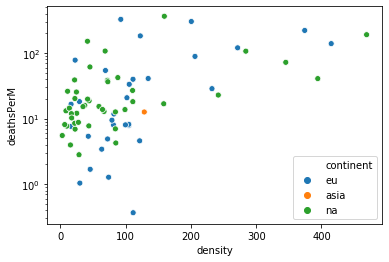

In [59]:
tmp = europe_v_states[europe_v_states.population >= 1E6]
lm = sns.scatterplot(x=tmp['density'],y=tmp['deathsPerM'],hue=tmp['continent'])
lm.axes.set_yscale('log')